[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


  Ticker        P/E        P/B  EV/EBITDA  Value Score
2  GOOGL  27.863497   7.680633  19.734821     1.000000
3   AMZN  50.991623   8.765065  20.445464     2.666667
1   MSFT  38.316610  13.005462  26.339330     3.000000
0   AAPL  34.830482  46.301430  26.781515     3.333333


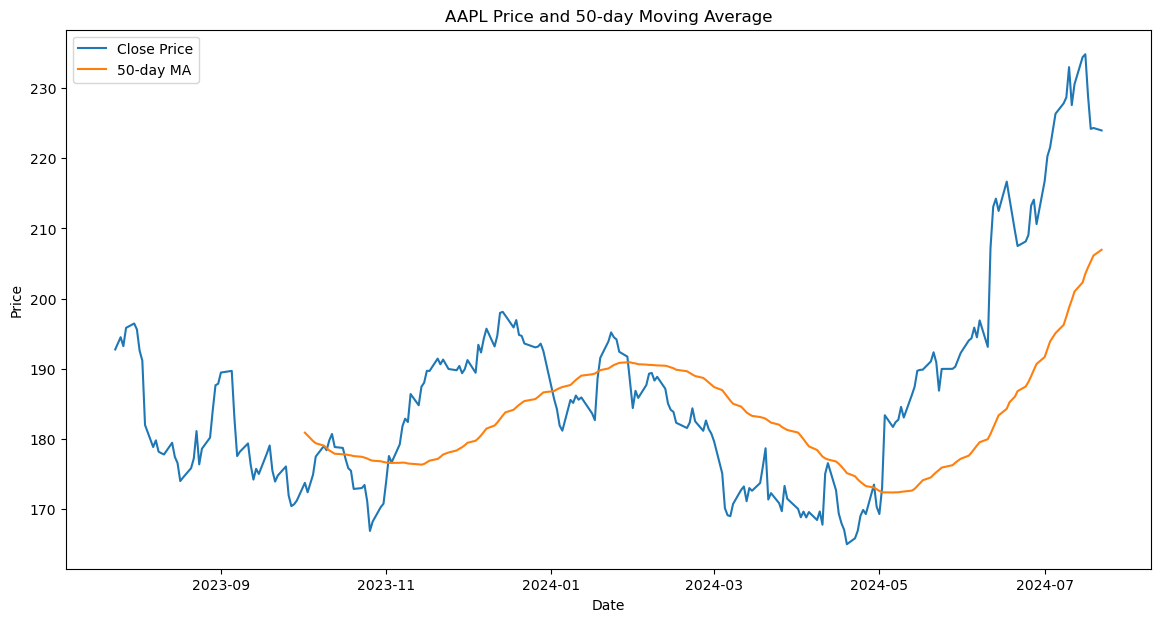

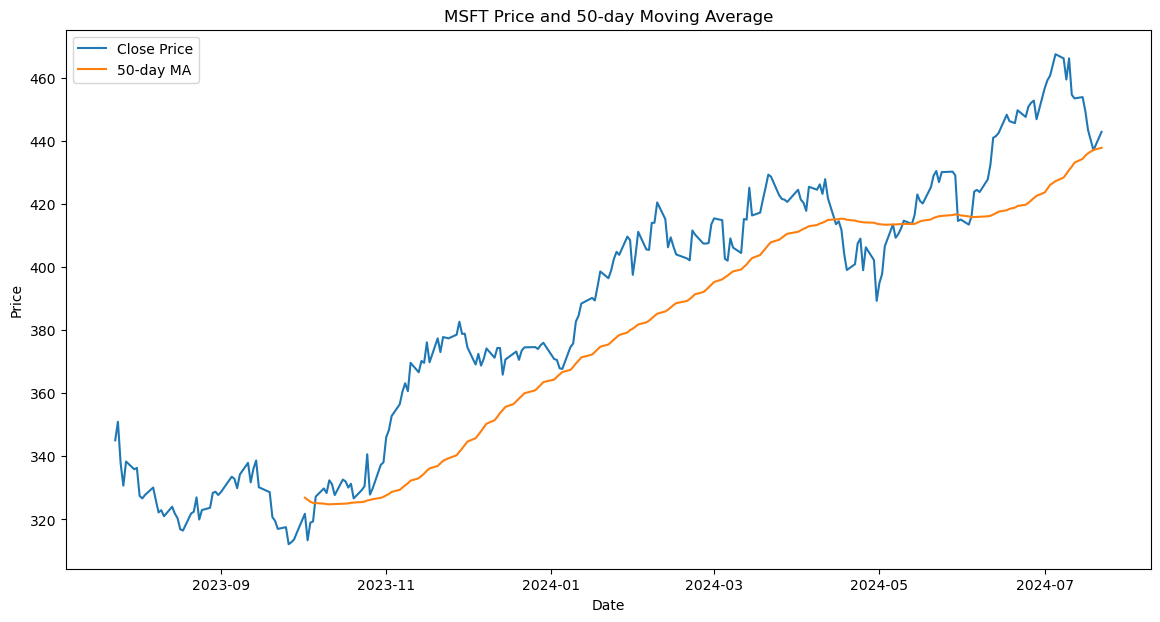

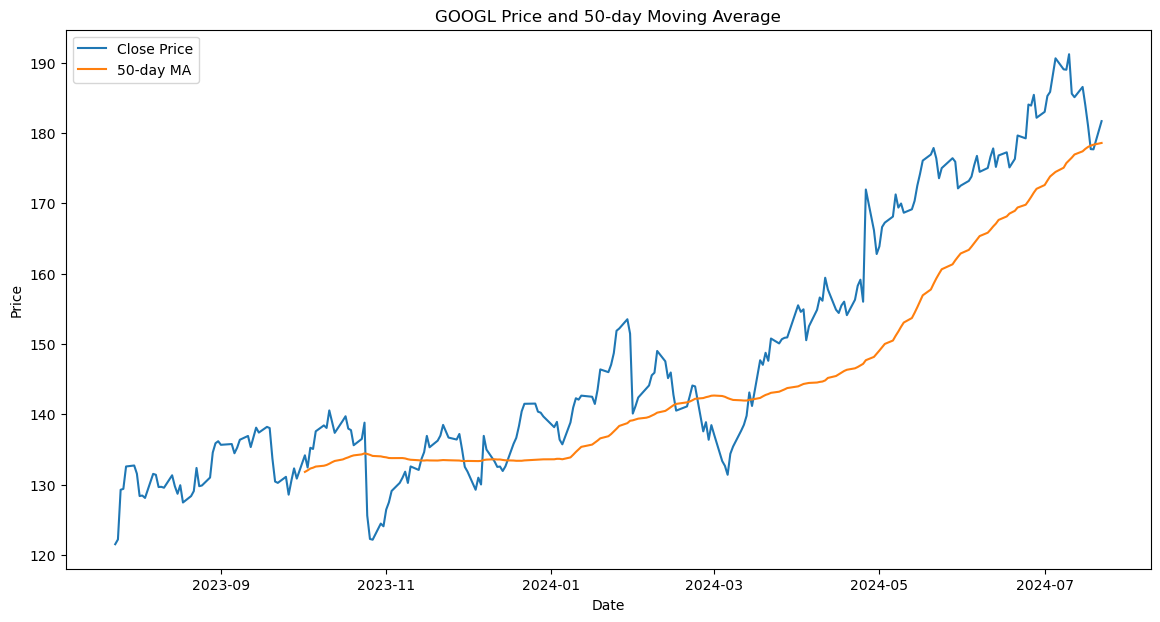

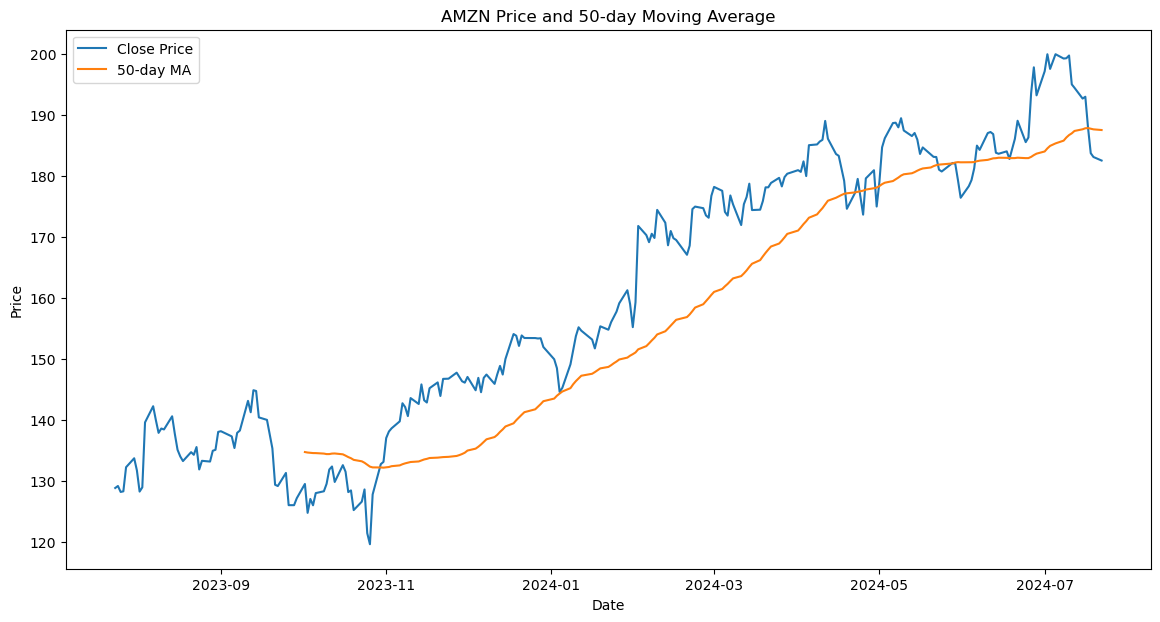

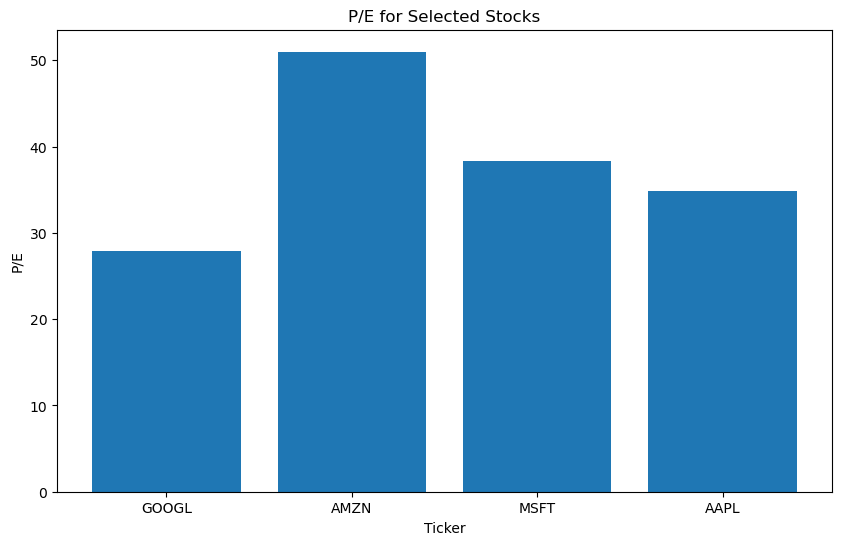

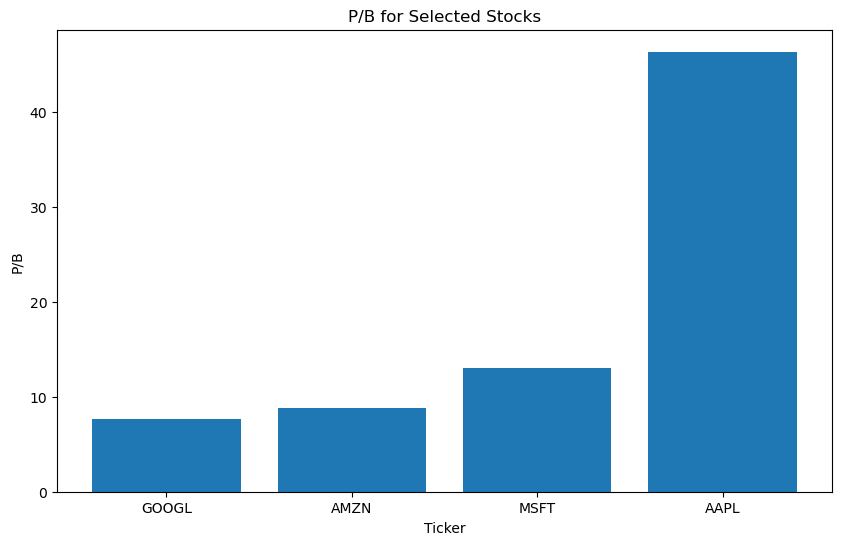

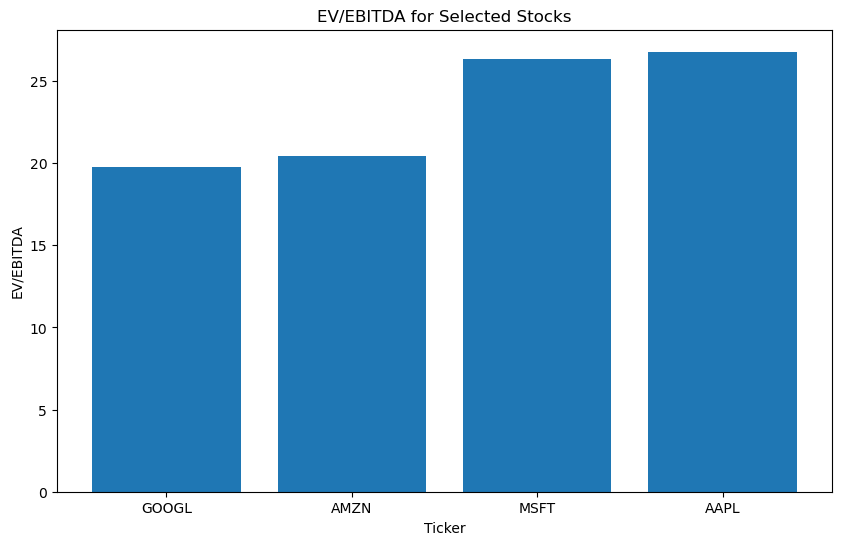

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Function to get historical price data for a given ticker (e.g. Apple, Microsoft)
def get_historical_data(ticker, period='1y'):
    data = yf.download(ticker, period=period)
    return data

# Quantitative Momentum Strategy: Calculate momentum based on past performance
def calculate_momentum(data, window=90):
    data['Momentum'] = data['Close'] / data['Close'].shift(window) - 1
    return data

# Quantitative Momentum Strategy: Calculate moving averages for momentum analysis
def calculate_moving_averages(data, window=50):
    data['MA'] = data['Close'].rolling(window=window).mean()
    return data


# Quantitative Value Strategy: Calculate value metrics such as P/E, P/B, and EV/EBITDA
def calculate_value_metrics(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    # Get financial metrics
    try:
        pe_ratio = info.get('trailingPE', np.nan)
        pb_ratio = info.get('priceToBook', np.nan)
        ev = info.get('enterpriseValue', np.nan)
        ebitda = info.get('ebitda', np.nan)
        ev_ebitda = ev / ebitda if ev and ebitda else np.nan
    
    #error handling
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {e}")
        pe_ratio = pb_ratio = ev_ebitda = np.nan

    return {
        'Ticker': ticker,
        'P/E': pe_ratio,
        'P/B': pb_ratio,
        'EV/EBITDA': ev_ebitda
    }

# Function to screen and rank stocks based on both strategies
def screen_and_rank_stocks(tickers, period='1y', ma_window=50, momentum_window=90):
    stock_data = {}
    value_metrics = []
    
    for ticker in tickers:
        # Get historical data
        data = get_historical_data(ticker, period)
        
        # Quantitative Momentum Strategy
        data = calculate_momentum(data, momentum_window)
        data = calculate_moving_averages(data, ma_window)
        
        stock_data[ticker] = data
        
        # Quantitative Value Strategy
        metrics = calculate_value_metrics(ticker)
        value_metrics.append(metrics)
    
    # Create a DataFrame for value metrics and rank the stocks
    value_df = pd.DataFrame(value_metrics)
    value_df['Value Score'] = value_df[['P/E', 'P/B', 'EV/EBITDA']].rank().mean(axis=1)
    value_df.sort_values('Value Score', inplace=True)
    
    return stock_data, value_df

# Example usage
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
stock_data, value_df = screen_and_rank_stocks(tickers)

# Display the ranked stocks based on value metrics
print(value_df)

# Plotting the momentum and moving averages
def plot_stock_data(stock_data, ticker):
    data = stock_data[ticker]
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['MA'], label='50-day MA')
    plt.title(f'{ticker} Price and 50-day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plot data for each ticker
for ticker in tickers:
    plot_stock_data(stock_data, ticker)

# Plotting the value metrics
def plot_value_metrics(value_df):
    metrics = ['P/E', 'P/B', 'EV/EBITDA']
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.bar(value_df['Ticker'], value_df[metric])
        plt.title(f'{metric} for Selected Stocks')
        plt.xlabel('Ticker')
        plt.ylabel(metric)
        plt.show()

# Plotting value metrics
plot_value_metrics(value_df)


#Information about Metrics------------

#Ticker: Google, Amazon, Microsoft, Apple

#P/E (Price-to-Earnings Ratio):
#This ratio measures the current share price relative to its per-share earnings. 
#A lower P/E ratio may indicate that the stock is undervalued or that the company is performing well relative to its current price.

#P/B (Price-to-Book Ratio):
#This ratio compares the market value of a company's stock with its book value. 
#A lower P/B ratio could suggest that the stock is undervalued.

#EV/EBITDA (Enterprise Value to Earnings Before Interest, Taxes, Depreciation, and Amortization):
#This ratio provides a comparison between the value of the company (including debt) and its earnings, adjusted for non-cash items. 
#Lower EV/EBITDA values generally indicate a potentially undervalued company.

#Value Score:
#The average rank of the stock based on the P/E, P/B, and EV/EBITDA ratios. 
#A lower Value Score indicates a better ranking and potentially a more attractive investment based on these value metrics.


#Analysing Metrics------------
#GOOGL has the best (lowest) Value Score, suggesting it is the most undervalued stock relative to the others in the table when considering P/E, P/B, and EV/EBITDA ratios.
#Therefore Google Stock it would be the better investment to make.

[*********************100%%**********************]  1 of 1 completed
C:\Users\prith\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


744/744 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0103
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


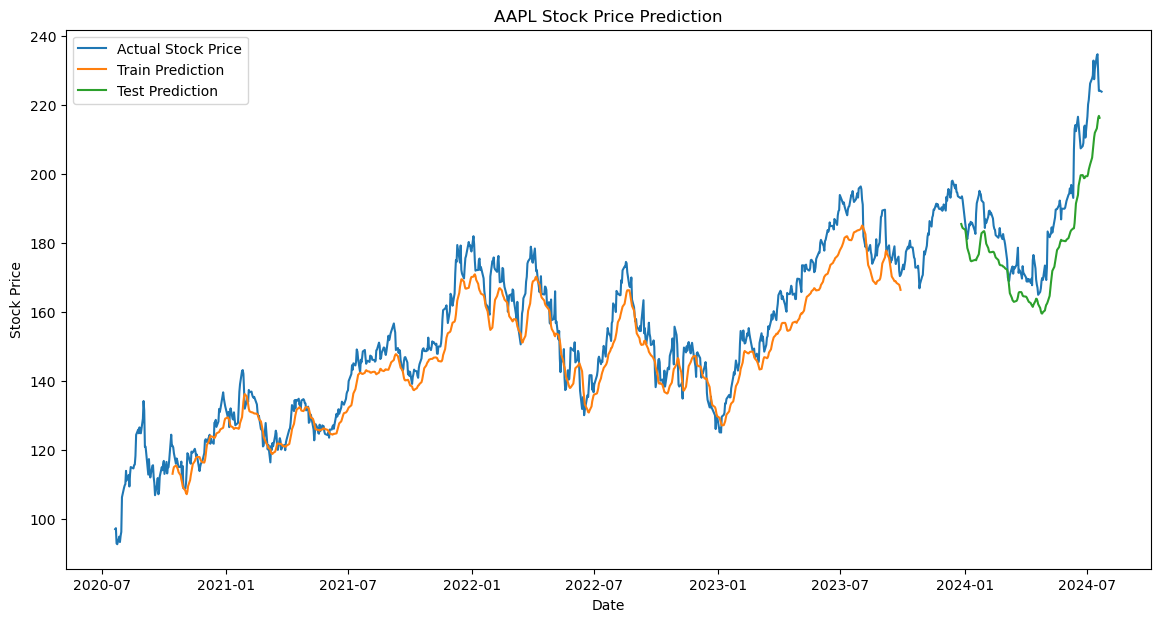

In [3]:
#Experimenting and training a ML model for Apple price stock with both strategies

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Function to get historical price data for a given ticker
def get_historical_data(ticker, period='5y'):
    data = yf.download(ticker, period=period)
    return data

# Function to calculate momentum
def calculate_momentum(data, period=60):
    data['Momentum'] = data['Close'].pct_change(periods=period)
    return data

# Function to calculate value (using simple P/E ratio approximation)
def calculate_value(data):
    data['PE_Ratio'] = data['Close'] / data['Close'].rolling(window=252).mean()
    data['Value_Score'] = 1 / data['PE_Ratio']
    return data

# Load data
ticker = 'AAPL'
data = get_historical_data(ticker, period='5y')

# Preprocess data: Add momentum and value scores
data = calculate_momentum(data)
data = calculate_value(data)
data = data[['Close', 'Momentum', 'Value_Score']].dropna()

# Scale data:
# Before training the LSTM model, the features are scaled (closing price, momentum, and value score) using the MinMaxScaler. 
# This ensures the features are on a similar scale, which helps the LSTM model to learn more effectively.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create dataset for LSTM (Long Short-Term Memory - recurrent neural network) model
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Make predictions:
# The model is trained on the scaled data, meaning that both the inputs (X) and the outputs (y) are scaled. 
# The predictions made by the model are therefore also in the scaled form.
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions:
# The inverse transformation converts the scaled predictions back to the original scale of the data. 
# This is important because it makes the results interpretable and comparable to the actual stock prices. 
train_predict = scaler.inverse_transform(np.hstack((train_predict, np.zeros((train_predict.shape[0], 2)))))
test_predict = scaler.inverse_transform(np.hstack((test_predict, np.zeros((test_predict.shape[0], 2)))))
y_train = scaler.inverse_transform(np.hstack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 2)))))
y_test = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2)))))

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Stock Price')
plt.plot(data.index[time_step:time_step+len(train_predict)], train_predict[:, 0], label='Train Prediction')
plt.plot(data.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)], test_predict[:, 0], label='Test Prediction')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
